In [2]:
# Importing libraries
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline


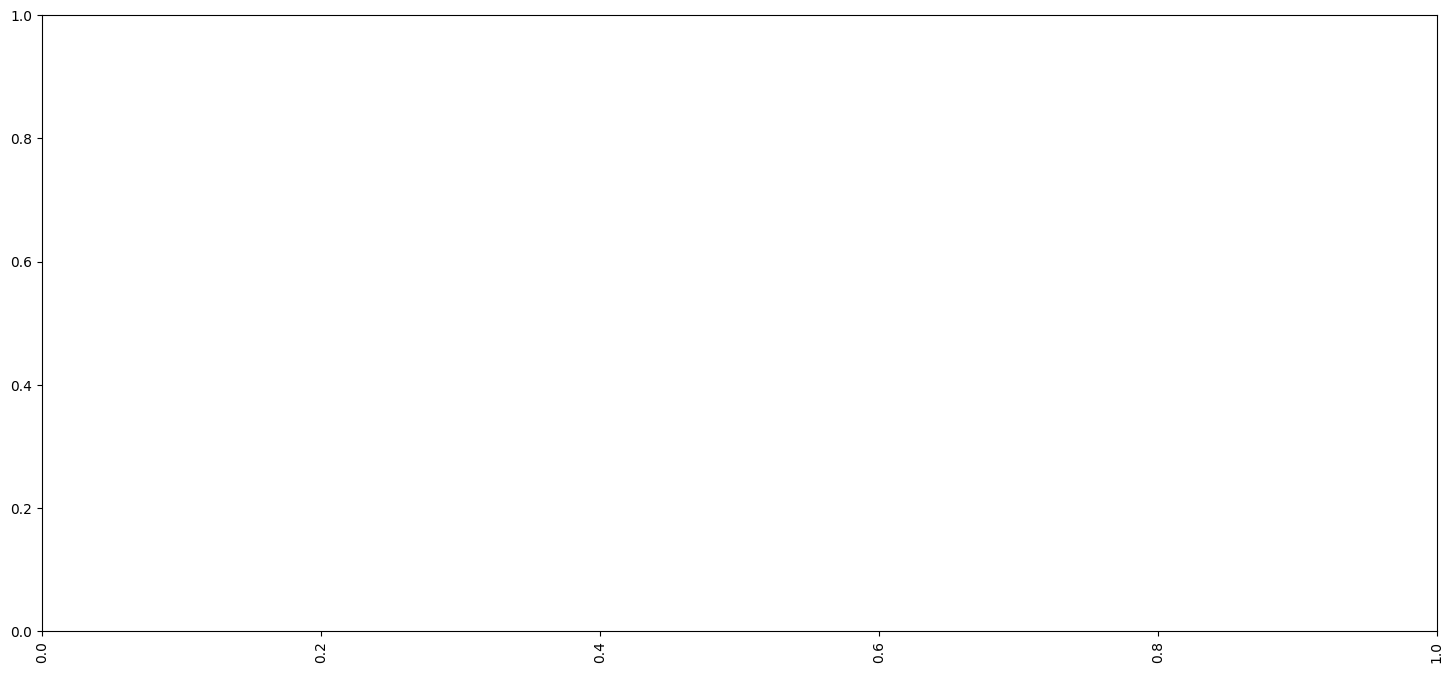

In [3]:
# Reading the train.csv by removing the
# last column since it's an empty column

data = pd.read_csv("training.csv").dropna(axis = 1)

# Checking whether the dataset is balanced or not
disease_counts = data["prognosis"].value_counts()
temp_df = pd.DataFrame({
	"Disease": disease_counts.index,
	"Counts": disease_counts.values
})

plt.figure(figsize = (18,8))
#sns.barplot(x = "Disease", y = "Counts", data = temp_df)
plt.xticks(rotation=90)
plt.show()


In [4]:
# Encoding the target value into numerical
# value using LabelEncoder
encoder = LabelEncoder()
data["prognosis"] = encoder.fit_transform(data["prognosis"])


In [5]:
X = data.iloc[:,:-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test =train_test_split(
X, y, test_size = 0.2, random_state = 24)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Train: (3936, 132), (3936,)
Test: (984, 132), (984,)


In [6]:
# Defining scoring metric for k-fold cross validation
def cv_scoring(estimator, X, y):
	return accuracy_score(y, estimator.predict(X))

# Initializing Models
models = {
	"SVC":SVC(),
	"Gaussian NB":GaussianNB(),
	"Random Forest":RandomForestClassifier(random_state=18)
}

# Producing cross validation score for the models
for model_name in models:
	model = models[model_name]
	scores = cross_val_score(model, X, y, cv = 10,
							n_jobs = -1,
							scoring = cv_scoring)
	print("=="*30)
	print(model_name)
	print(f"Scores: {scores}")
	print(f"Mean Score: {np.mean(scores)}")


SVC
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
Gaussian NB
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0
Random Forest
Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean Score: 1.0


In [ ]:
# Training and testing SVM Classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)
preds = svm_model.predict(X_test)

print(f"Accuracy on train data by SVM Classifier\
: {accuracy_score(y_train, svm_model.predict(X_train))*100}")

print(f"Accuracy on test data by SVM Classifier\
: {accuracy_score(y_test, preds)*100}")
cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
#sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for SVM Classifier on Test Data")
plt.show()

# Training and testing Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
preds = nb_model.predict(X_test)
print(f"Accuracy on train data by Naive Bayes Classifier\
: {accuracy_score(y_train, nb_model.predict(X_train))*100}")

print(f"Accuracy on test data by Naive Bayes Classifier\
: {accuracy_score(y_test, preds)*100}")
cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
#sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Naive Bayes Classifier on Test Data")
plt.show()

# Training and testing Random Forest Classifier
rf_model = RandomForestClassifier(random_state=18)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)
print(f"Accuracy on train data by Random Forest Classifier\
: {accuracy_score(y_train, rf_model.predict(X_train))*100}")

print(f"Accuracy on test data by Random Forest Classifier\
: {accuracy_score(y_test, preds)*100}")

cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
#sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Random Forest Classifier on Test Data")
plt.show()


In [ ]:
# Training the models on whole data
final_svm_model = SVC()
final_nb_model = GaussianNB()
final_rf_model = RandomForestClassifier(random_state=18)
final_svm_model.fit(X, y)
final_nb_model.fit(X, y)
final_rf_model.fit(X, y)

# Reading the test data
test_data = pd.read_csv("testing.csv").dropna(axis=1)

test_X = test_data.iloc[:, :-1]
test_Y = encoder.transform(test_data.iloc[:, -1])

# Making prediction by take mode of predictions
# made by all the classifiers
svm_preds = final_svm_model.predict(test_X)
nb_preds = final_nb_model.predict(test_X)
rf_preds = final_rf_model.predict(test_X)

final_preds = [mode([i,j,k])[0][0] for i,j,
			k in zip(svm_preds, nb_preds, rf_preds)]

print(f"Accuracy on Test dataset by the combined model\
: {accuracy_score(test_Y, final_preds)*100}")

cf_matrix = confusion_matrix(test_Y, final_preds)
plt.figure(figsize=(12,8))

#sns.heatmap(cf_matrix, annot = True)
plt.title("Confusion Matrix for Combined Model on Test Dataset")
plt.show()


In [27]:
symptoms = X.columns.values

# Creating a symptom index dictionary to encode the
# input symptoms into numerical form
symptom_index = {}
for index, value in enumerate(symptoms):
	symptom = " ".join([i.capitalize() for i in value.split("_")])
	symptom_index[symptom] = index
print(symptoms)
data_dict = {
	"symptom_index":symptom_index,
	"predictions_classes":encoder.classes_
}

# Defining the Function
# Input: string containing symptoms separated by commas
# Output: Generated predictions by models
def predictDisease(symptoms):
	symptoms = symptoms.split(",")
	
	# creating input data for the models
	input_data = [0] * len(data_dict["symptom_index"])
	for symptom in symptoms:
		index = data_dict["symptom_index"][symptom]
		input_data[index] = 1
		
	# reshaping the input data and converting it
	# into suitable format for model predictions
	input_data = np.array(input_data).reshape(1,-1)
	
	# generating individual outputs
	rf_prediction = data_dict["predictions_classes"][final_rf_model.predict(input_data)[0]]
	nb_prediction = data_dict["predictions_classes"][final_nb_model.predict(input_data)[0]]
	svm_prediction = data_dict["predictions_classes"][final_svm_model.predict(input_data)[0]]
	
	# making final prediction by taking mode of all predictions
	final_prediction = mode([rf_prediction, nb_prediction, svm_prediction])[0][0]
	predictions = {
		"rf_model_prediction": rf_prediction,
		"naive_bayes_prediction": nb_prediction,
		"svm_model_prediction": nb_prediction,
		"final_prediction":final_prediction
	}
	return predictions

# Testing the function
print(predictDisease("Constipation,Stomach Pain,Bladder Discomfort"))


['itching' 'skin_rash' 'nodal_skin_eruptions' 'continuous_sneezing'
 'shivering' 'chills' 'joint_pain' 'stomach_pain' 'acidity'
 'ulcers_on_tongue' 'muscle_wasting' 'vomiting' 'burning_micturition'
 'spotting_ urination' 'fatigue' 'weight_gain' 'anxiety'
 'cold_hands_and_feets' 'mood_swings' 'weight_loss' 'restlessness'
 'lethargy' 'patches_in_throat' 'irregular_sugar_level' 'cough'
 'high_fever' 'sunken_eyes' 'breathlessness' 'sweating' 'dehydration'
 'indigestion' 'headache' 'yellowish_skin' 'dark_urine' 'nausea'
 'loss_of_appetite' 'pain_behind_the_eyes' 'back_pain' 'constipation'
 'abdominal_pain' 'diarrhoea' 'mild_fever' 'yellow_urine'
 'yellowing_of_eyes' 'acute_liver_failure' 'fluid_overload'
 'swelling_of_stomach' 'swelled_lymph_nodes' 'malaise'
 'blurred_and_distorted_vision' 'phlegm' 'throat_irritation'
 'redness_of_eyes' 'sinus_pressure' 'runny_nose' 'congestion' 'chest_pain'
 'weakness_in_limbs' 'fast_heart_rate' 'pain_during_bowel_movements'
 'pain_in_anal_region' 'bloody_

c:\Users\G Naveen Chandra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\G Naveen Chandra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\G Naveen Chandra\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\G Naveen Chandra\AppData\Local\Temp\ipykernel_10376\1691491693.py:37: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over whic

In [1]:
s="nani chandra"
print(s.split())

['nani', 'chandra']


In [ ]:

   ''' Disease Detection using Symptoms and Treatment recommendation
    This notebook contains code to detect disease using the symptoms entered and selected by the user and recommends the appropriate treatments.
'''

# Predicts diseases based on the symptoms entered and selected by the user.
# importing all necessary libraries
import warnings
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score
from statistics import mean
from nltk.corpus import wordnet 
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from itertools import combinations
from time import time
from collections import Counter
import operator
from xgboost import XGBClassifier
import math
from Treatment import diseaseDetail
from sklearn.linear_model import LogisticRegression

warnings.simplefilter("ignore")
     
Download resources required for NLTK pre-processing


import nltk
nltk.download('all')
     
'''synonyms function finds the synonymous terms of a symptom entered by the user.

This is necessary as the user may use a term for a symptom which may be different from the one present in dataset. This improves the accuracy by reducing the wrong predictions even when symptoms for a disease are entered slightly different than the ones on which model is trained.

Synonyms are searched on Thesaurus.com and NLTK Wordnet'''


# returns the list of synonyms of the input word from thesaurus.com (https://www.thesaurus.com/) and wordnet (https://www.nltk.org/howto/wordnet.html)
def synonyms(term):
    synonyms = []
    response = requests.get('https://www.thesaurus.com/browse/{}'.format(term))
    soup = BeautifulSoup(response.content,  "html.parser")
    try:
        container=soup.find('section', {'class': 'MainContentContainer'}) 
        row=container.find('div',{'class':'css-191l5o0-ClassicContentCard'})
        row = row.find_all('li')
        for x in row:
            synonyms.append(x.get_text())
    except:
        None
    for syn in wordnet.synsets(term):
        synonyms+=syn.lemma_names()
    return set(synonyms)
     

# utlities for pre-processing
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
splitter = RegexpTokenizer(r'\w+')
     
'''Disease Symptom dataset was created in a separate python program.

Dataset scrapping was done using NHP website and wikipedia data

Disease Combination dataset contains the combinations for each of the disease present in dataset as practically it is often observed that it is not necessary for a person to have a disease when all the symptoms are faced by the patient or the user.

To tackle this problem, combinations are made with the symptoms for each disease.

This increases the size of the data exponentially and helps the model to predict the disease with much better accuracy.

df_comb -> Dataframe consisting of dataset generated by combining symptoms for each disease.

df_norm -> Dataframe consisting of dataset which contains a single row for each diseases with all the symptoms for that corresponding disease.

Dataset contains 261 diseases and their symptoms'''


# Load Dataset scraped from NHP (https://www.nhp.gov.in/disease-a-z) & Wikipedia
# Scrapping and creation of dataset csv is done in a separate program
df_comb = pd.read_csv("/content/drive/My Drive/Python Project data/IR_Project/dis_sym_dataset_comb.csv") # Disease combination
df_norm = pd.read_csv("/content/drive/My Drive/Python Project data/IR_Project/dis_sym_dataset_norm.csv") # Individual Disease

X = df_comb.iloc[:, 1:]
Y = df_comb.iloc[:, 0:1]
     
'''Using Logistic Regression (LR) Classifier as it gives better accuracy compared to other classification models as observed in the comparison of model accuracies in Model_latest.py

Cross validation is done on dataset with cv = 5'''


lr = LogisticRegression()
lr = lr.fit(X, Y)
scores = cross_val_score(lr, X, Y, cv=5)
     

X = df_norm.iloc[:, 1:]
Y = df_norm.iloc[:, 0:1]
     

# List of symptoms
dataset_symptoms = list(X.columns)
     
#Symptoms initially taken from user.

# Taking symptoms from user as input 
user_symptoms = str(input("Please enter symptoms separated by comma(,):\n")).lower().split(',')
# Preprocessing the input symptoms
processed_user_symptoms=[]
for sym in user_symptoms:
    sym=sym.strip()
    sym=sym.replace('-',' ')
    sym=sym.replace("'",'')
    sym = ' '.join([lemmatizer.lemmatize(word) for word in splitter.tokenize(sym)])
    processed_user_symptoms.append(sym)
     
'''Please enter symptoms separated by comma(,):
coughing,pyrexia,tire,loss of smell
Pre-processing on symptoms entered by user is done.'''


# Taking each user symptom and finding all its synonyms and appending it to the pre-processed symptom string
user_symptoms = []
for user_sym in processed_user_symptoms:
    user_sym = user_sym.split()
    str_sym = set()
    for comb in range(1, len(user_sym)+1):
        for subset in combinations(user_sym, comb):
            subset=' '.join(subset)
            subset = synonyms(subset) 
            str_sym.update(subset)
    str_sym.add(' '.join(user_sym))
    user_symptoms.append(' '.join(str_sym).replace('_',' '))
# query expansion performed by joining synonyms found for each symptoms initially entered
print("After query expansion done by using the symptoms entered")
print(user_symptoms)
     
'''After query expansion done by using the symptoms entered
['bark expectorate hack cough coughing hem hawk clear throat vomit choke spit up convulse whoop', 'climate febricity febrility condition incalescence pyrexia warmth body heat cold feverishness heat fever thermal reading calefaction degrees', 'droop annoy bush irritate tyre nauseate deject wear overtax wilt disgust weaken drop fatigue sink play out poop out vex yawn sicken tire out collapse give out outwear flag debilitate irk distress overstrain displease go stale fag out exasperate run down sap crawl pall fail enervate overburden jade wear out fold overwork tax exhaust strain depress faint fag drain harass dispirit weary wear down wear upon dishearten wear down burn out put to sleep prostrate peter out bore grow weary tire worry wear out ennui pain', 'privation cost forfeiture harm redolence losing hurt misplacing loss of smell trail red ink going showing whiff stench failure olfactory perception like coming from out of want perdition as regards debt destitution impairment bad luck flavor attributed to expiration need departure characterized by out from containing personnel casualty detriment made from trial smack fall olfactory modality scent wreckage proceeding from bouquet depletion catastrophe in regard to related to accident belonging to savor tone smell out pertaining to defeat trace fragrance fatality tang perfume sacrifice loss debit disappearance cataclysm as concerns appropriate to smell olfactory property undoing red peculiar to passing disadvantage spirit emanation disaster death odour reek mislaying exit feeling retardation sense of smell smelling going from olfaction shrinkage odor connected with sense trouble spice squandering incense olfactory sensation deprivation bereavement misadventure consisting of calamity regarding based on dispossession mishap essence aroma appertaining to about deficiency ruin stink release in reference to referring to epithetical feel casualty injury destruction damage concerning away from look waste flavour']
The below procedure is performed in order to show the symptom synonmys found for the symptoms entered by the user.

The symptom synonyms and user symptoms are matched with the symptoms present in dataset. Only the symptoms which matches the symptoms present in dataset are shown back to the user.
'''

# Loop over all the symptoms in dataset and check its similarity score to the synonym string of the user-input 
# symptoms. If similarity>0.5, add the symptom to the final list
found_symptoms = set()
for idx, data_sym in enumerate(dataset_symptoms):
    data_sym_split=data_sym.split()
    for user_sym in user_symptoms:
        count=0
        for symp in data_sym_split:
            if symp in user_sym.split():
                count+=1
        if count/len(data_sym_split)>0.5:
            found_symptoms.add(data_sym)
found_symptoms = list(found_symptoms)
     
#Prompt the user to select the relevant symptoms by entering the corresponding indices.

# Print all found symptoms
print("Top matching symptoms from your search!")
for idx, symp in enumerate(found_symptoms):
    print(idx,":",symp)
    
# Show the related symptoms found in the dataset and ask user to select among them
select_list = input("\nPlease select the relevant symptoms. Enter indices (separated-space):\n").split()

# Find other relevant symptoms from the dataset based on user symptoms based on the highest co-occurance with the
# ones that is input by the user
dis_list = set()
final_symp = [] 
counter_list = []
for idx in select_list:
    symp=found_symptoms[int(idx)]
    final_symp.append(symp)
    dis_list.update(set(df_norm[df_norm[symp]==1]['label_dis']))
   
for dis in dis_list:
    row = df_norm.loc[df_norm['label_dis'] == dis].values.tolist()
    row[0].pop(0)
    for idx,val in enumerate(row[0]):
        if val!=0 and dataset_symptoms[idx] not in final_symp:
            counter_list.append(dataset_symptoms[idx])
     
'''Top matching symptoms from your search!
0 : coughing
1 : red
2 : feeling need urinate right away
3 : loss smell
4 : fatigue
5 : trouble sensation
6 : fever
7 : crawl
8 : feeling like passing

Please select the relevant symptoms. Enter indices (separated-space):
0 3 4 6
To find symptoms which generally co-occur, for example with symptoms like cough, headache generally happens hence they co-occur.
'''
# Symptoms that co-occur with the ones selected by user              
dict_symp = dict(Counter(counter_list))
dict_symp_tup = sorted(dict_symp.items(), key=operator.itemgetter(1),reverse=True)   
#print(dict_symp_tup) 
     
User is presented with a list of co-occuring symptoms to select from and is performed iteratively to recommend more possible symptoms based on the similarity to the previously entered symptoms.
As the co-occuring symptoms can be in overwhelming numbers, only the top 5 are recommended to the user from which user can select the symptoms.

If user does not have any of those 5 symptoms and wants to see the next 5, he can do so by giving input as -1.

To stop the recommendation, user needs to give input as "No".


# Iteratively, suggest top co-occuring symptoms to the user and ask to select the ones applicable 
found_symptoms=[]
count=0
for tup in dict_symp_tup:
    count+=1
    found_symptoms.append(tup[0])
    if count%5==0 or count==len(dict_symp_tup):
        print("\nCommon co-occuring symptoms:")
        for idx,ele in enumerate(found_symptoms):
            print(idx,":",ele)
        select_list = input("Do you have have of these symptoms? If Yes, enter the indices (space-separated), 'no' to stop, '-1' to skip:\n").lower().split();
        if select_list[0]=='no':
            break
        if select_list[0]=='-1':
            found_symptoms = [] 
            continue
        for idx in select_list:
            final_symp.append(found_symptoms[int(idx)])
        found_symptoms = [] 
     
'''Common co-occuring symptoms:
0 : headache
1 : testicular pain
2 : vomiting
3 : sore throat
4 : barky cough
Do you have have of these symptoms? If Yes, enter the indices (space-separated), 'no' to stop, '-1' to skip:
-1

Common co-occuring symptoms:
0 : maculopapular rash
1 : confusion
2 : diarrhea
3 : runny nose
4 : shortness breath
Do you have have of these symptoms? If Yes, enter the indices (space-separated), 'no' to stop, '-1' to skip:
4

Common co-occuring symptoms:
0 : feeling tired
1 : swollen lymph node
2 : unintended weight loss
3 : chest pain
4 : tiredness
Do you have have of these symptoms? If Yes, enter the indices (space-separated), 'no' to stop, '-1' to skip:
no
Final Symptom list'''


# Create query vector based on symptoms selected by the user
print("\nFinal list of Symptoms that will be used for prediction:")
sample_x = [0 for x in range(0,len(dataset_symptoms))]
for val in final_symp:
    print(val)
    sample_x[dataset_symptoms.index(val)]=1
     
'''Final list of Symptoms that will be used for prediction:
coughing
loss smell
fatigue
fever
shortness breath
Prediction of disease is done'''


# Predict disease
lr = LogisticRegression()
lr = lr.fit(X, Y)
prediction = lr.predict_proba([sample_x])
     
'''Show top k diseases and their probabilities to the user.

K in this case is 10'''


k = 10
diseases = list(set(Y['label_dis']))
diseases.sort()
topk = prediction[0].argsort()[-k:][::-1]
     
'''Showing the list of top k diseases to the user with their prediction probabilities.
For getting information about the suggested treatments, user can enter the corresponding index to know more details.'''

print(f"\nTop {k} diseases predicted based on symptoms")
topk_dict = {}
# Show top 10 highly probable disease to the user.
for idx,t in  enumerate(topk):
    match_sym=set()
    row = df_norm.loc[df_norm['label_dis'] == diseases[t]].values.tolist()
    row[0].pop(0)

    for idx,val in enumerate(row[0]):
        if val!=0:
            match_sym.add(dataset_symptoms[idx])
    prob = (len(match_sym.intersection(set(final_symp)))+1)/(len(set(final_symp))+1)
    prob *= mean(scores)
    topk_dict[t] = prob
j = 0
topk_index_mapping = {}
topk_sorted = dict(sorted(topk_dict.items(), key=lambda kv: kv[1], reverse=True))
for key in topk_sorted:
  prob = topk_sorted[key]*100
  print(str(j) + " Disease name:",diseases[key], "\tProbability:",str(round(prob, 2))+"%")
  topk_index_mapping[j] = key
  j += 1

select = input("\nMore details about the disease? Enter index of disease or '-1' to discontinue and close the system:\n")
if select!='-1':
    dis=diseases[topk_index_mapping[int(select)]]
    print()
    print(diseaseDetail(dis))
     
'''Top 10 diseases predicted based on symptoms
0 Disease name: Coronavirus disease 2019 (COVID-19) 	Probability: 74.33%
1 Disease name: Asthma 	Probability: 44.6%
2 Disease name: Middle East respiratory syndrome coronavirus (MERS‐CoV) 	Probability: 44.6%
3 Disease name: Legionellosis 	Probability: 44.6%
4 Disease name: Influenza 	Probability: 44.6%
5 Disease name: Brucellosis 	Probability: 29.73%
6 Disease name: Chronic obstructive pulmonary disease (COPD) 	Probability: 29.73%
7 Disease name: Neonatal Respiratory Disease Syndrome(NRDS) 	Probability: 29.73%
8 Disease name: Coronary Heart Disease 	Probability: 29.73%
9 Disease name: Pulmonary embolism 	Probability: 29.73%

More details about the disease? Enter index of disease or '-1' to discontinue and close the system:
0

Coronavirus disease 2019 (COVID-19)
Other names -  
  Coronavirus 
 COVID 
 2019-nCoV acute respiratory disease 
 Novel coronavirus pneumonia   
 Severe pneumonia with novel pathogens    
 
Pronunciation -          /  k  ə  ˈ  r  oʊ  n  ə  ˌ  v  aɪ  r  ə  s       d  ɪ  ˈ  z  iː  z  /      /  ˌ  k  oʊ  v  ɪ  d  n  aɪ  n  ˈ  t  iː  n  ,     ˌ  k  ɒ  v  ɪ  d  -/            
Specialty -  Infectious disease 
Symptoms -  Fever, cough, fatigue, shortness of breath, loss of smell, sometimes no symptoms at all   
Complications -  Pneumonia, viral sepsis, acute respiratory distress syndrome, kidney failure, cytokine release syndrome 
Usual onset -  2–14 days (typically 5) from infection 
Causes -  Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) 
Risk factors -  Travel, viral exposure 
Diagnostic method -  rRT-PCR testing, CT scan 
Prevention -  Hand washing, face coverings, quarantine, social distancing   
Treatment -  Symptomatic and supportive 
Frequency -  4,444,670   confirmed cases 
Deaths -  302,493 (  68% of confirmed cases)   '''


In [10]:
import csv
with open("To_process2_fin.csv") as f:
    data=f.readlines()
risk=[]
for line in data:
    result=[]
    if line.find("On the other hand")>0: 
     if line.find("age")<(line.find("On the other hand")):
        
        end_pt=line.find("On the other hand")
        
        age_ind=[i for i in range(end_pt) if line.startswith("age",i,end_pt)]
        for l_ind in age_ind:
                age = line[l_ind+3:line.find("years", l_ind)]
                result.append(age)
        risk.append(result)
     else:
         risk.append(["NULL"])
    elif line.find("Within all the people")>0:
        if line.find("age")<(line.find("Within all the people")):
        
            end_pt=line.find("Within all the people")
        
            age_ind=[i for i in range(end_pt) if line.startswith("age",i,end_pt)]
            for l_ind in age_ind:
                    age = line[l_ind+3:line.find("years", l_ind)]
                    result.append(age)
            risk.append(result)
        else:
            risk.append(["NULL"])

print(risk)
k=["riskers"]
with open("mydata1.csv","w") as f:
    csv_writer=csv.writer(f)
    csv_writer.writerow(k)
    csv_writer.writerows(risk)
    


[[' 30-44 '], [' 60-74 ', ' 45-59 '], [' 5-14 ', ' 1-4 '], [' 5-14 ', ' 1-4 ', ' < 1 '], [' 15-29 ', ' 45-59 '], [' 75+ ', ' 60-74 ', ' 45-59 '], [' 5-14 ', ' 15-29 '], ['NULL'], [' 5-14 ', ' 1-4 ', ' < 1 '], [' 30-44 ', ' 15-29 '], [' 1-4 ', ' < 1 '], [' 60-74 '], [' 5-14 '], [' 45-59 '], [' 60-74 '], [' 30-44 ', ' 15-29 '], [' 75+ '], [' 60-74 '], [' 75+ ', ' 60-74 '], [' 15-29 '], [' 75+ ', ' 60-74 '], [' 15-29 '], [' 60-74 ', ' 45-59 '], [' 30-44 ', ' 45-59 '], [' 15-29 '], [' 60-74 ', ' 45-59 '], [' 75+ ', ' 60-74 '], [], [' 75+ ', ' 60-74 '], ['NULL'], [' 60-74 ', ' 45-59 '], [' 75+ ', ' 60-74 '], [' 75+ '], [' 30-44 ', ' 75+ ', ' 60-74 ', ' 5-14 ', ' 1-4 ', ' 15-29 ', ' 45-59 ', ' < 1 '], [' 75+ ', ' 60-74 ', ' 45-59 '], [' 45-59 '], [' 75+ ', ' 60-74 '], [' 5-14 ', ' 1-4 ', ' < 1 '], [' 60-74 '], [' 5-14 ', ' 15-29 '], [' 45-59 '], [' 75+ ', ' 60-74 '], [' 5-14 ', ' 1-4 '], [' 15-29 '], [' 60-74 ', ' 45-59 '], [' 5-14 ', ' 15-29 ', ' < 1 '], [' 30-44 ', ' 15-29 '], [' 30-44 ', 